In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from statsmodels.tsa import stattools
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import random
import copy
import scipy
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *
from buildsys_funcs import *

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
#dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
dep_var_names = ['Fans:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly']#, 'DayType']

poly_degree = 2 #5
order = 8#26
lag = 140 #160

### Train A on full year, assume true A

Train A on the full year, assume true A, learn decision boundary. Transfer A with small # of samples. Train new decision boundary with those samples + transfered A. Test.

In [3]:
#building specific var names

zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array(datapath + "refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

In [4]:
X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=True, split_prop=0.8)
X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
X_val, Y_val = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)

#kernelize
X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
X_val_poly = polynomial_kernel_mat(X_val, poly_degree)

#initialize network
params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
net = linear_nnet(params)

#train linear state estimator
reg = None
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_poly.T, Y_train.T)

print("Validation MSE: ", mean_squared_error(Y_val.T, reg.coef_.dot(X_val_poly).T, multioutput='uniform_average'))

A = reg.coef_

#with torch:
#train_linear_state_estimation(net, params, X_train_poly, X_val_poly, Y_train, Y_val, epochs=1000, batch_size=100)
#torch.save(net, "seattle_state_transition_net.torch")

Validation MSE:  0.0016127085505622631


In [5]:
A.shape

(4, 84)

[[-1.16063101 -0.01651797 -0.05417798  0.33559756  0.35534481 -0.111703
  -0.04620306 -0.10416404  0.24421257  0.2704179 ]
 [ 0.00226577  0.00545013  0.00519849  0.0102252   0.01892982  0.02282282
   0.01672607 -0.01333996 -0.0080681  -0.00726879]
 [ 0.00226412  0.00544611  0.00519467  0.01021771  0.01891589  0.022806
   0.01671382 -0.01333015 -0.00806213 -0.00726343]
 [ 0.00226394  0.00544612  0.00519469  0.01021775  0.01891589  0.02280602
   0.01671384 -0.01333007 -0.00806212 -0.00726338]]


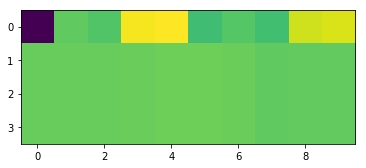

In [6]:
plt.imshow(A[:,0:10])
print(A[:,0:10])
plt.show()

### Load normal operating data and fault data

In [7]:
zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array(datapath + "refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre, Y_all_pre, X_v, Y_v = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_all, Y_all = normalize_data_set(X_all_pre, Y_all_pre, X_all_pre)

#kernelize
X_all_poly = polynomial_kernel_mat(X_all, poly_degree)

In [8]:
zone_temp_inds = [863,864,865]

Z_f, X_f, U_f = read_total_data_array(datapath + "refbuild_med_airfault/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre_f, Y_all_pre_f, X_v_f, Y_v_f = split_train_val(Z_f, X_f, U_f, order=order, shuff=False, split_prop=1.0)
X_all_f, Y_all_f = normalize_data_set(X_all_pre_f, Y_all_pre_f, X_all_pre)

#kernelize
X_all_poly_f = polynomial_kernel_mat(X_all_f, poly_degree)

In [9]:
X, Y, X_f, Y_f = sample_classification_transform(A, X_all_poly, X_all_poly_f, Y_all, Y_all_f)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  63.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  63.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [10]:
print(X.shape, Y.shape, X_f.shape, Y_f.shape)

(5, 6399) (1, 6399) (5, 6399) (1, 6399)


In [11]:
#reformat for sklearn 

X_lag_nf = lag_samples_array(X, lag)
Y_lag_nf = np.zeros((1,X_lag_nf.shape[1]))
    
X_lag_f = lag_samples_array(X_f, lag)
Y_lag_f = np.ones((1,X_lag_f.shape[1]))
    
X_sk = np.hstack((X_lag_nf, X_lag_f))
Y_sk = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [12]:
#shuffle and train/val split

train_vals = np.random.choice(X_sk.shape[1], int(0.8*X_sk.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X_sk.shape[1]) if i not in train_vals ])

X_train_log_reg = X_sk[:,train_vals]
Y_train_log_reg = Y_sk[:,train_vals]

X_val_log_reg = X_sk[:,vals]
Y_val_log_reg = Y_sk[:,vals]

In [13]:
#train logistic regression classifier for fault/no fault
logreg_model_obj = None #clear previous model cache if one exists --- speeds up training

logreg_model_obj = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1)#, n_jobs=-1, solver="saga")
logreg_model_obj.fit(X_train_log_reg.T, Y_train_log_reg.T)

Y_hat = logreg_model_obj.predict(X_train_log_reg.T)

p = sklearn.metrics.precision_score(Y_train_log_reg.T, Y_hat.T)
r = sklearn.metrics.recall_score(Y_train_log_reg.T, Y_hat.T)

print("Training precision: ", p)
print("Training recall: ", r)

Y_hat_val = logreg_model_obj.predict(X_val_log_reg.T)

p = sklearn.metrics.precision_score(Y_val_log_reg.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_log_reg.T, Y_hat_val.T)

print("Validation precision: ", p)
print("Validation recall: ", r)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]Training precision:  0.6424693344057912
Training recall:  0.6383616383616384
Validation precision:  0.5801587301587302
Validation recall:  0.5829346092503987


In [34]:
print(2*((0.58798)*(0.56131))/((0.58798)+(0.56131)))

0.5743355529065771


In [34]:
from buildsys_funcs import *

#initialize network
params = {'FEATURE_DIM': X_train_nn_log.shape[0], 'OUTPUT_DIM': 2}
net = linear_nnet(params)

#train logistic regression
train_linear_state_estimation(net, params, X_train_nn_log, X_val_nn_log, Y_train_nn_log, Y_val_nn_log, lrate=0.00001, epochs=50000, batch_size=500, l="bce")

torch.save(net, "seattle_logistic_classifier_net.torch")


Using Binary Cross Entropy Loss
Validation MSE:  tensor(26.1922, grad_fn=<NllLossBackward>)


In [29]:
#Y_hat_val = torch.argmax(net(Variable(torch.Tensor(X_val_nn_log.T))), dim=1).numpy()
#print(Y_hat_val)

In [36]:
p = sklearn.metrics.precision_score(Y_val_log_reg.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_log_reg.T, Y_hat_val.T)

print("Validation precision: ", p)
print("Validation recall: ", r)

Validation precision:  0.4884185303514377
Validation recall:  1.0


In [14]:
#classify a elements of a sequence, +1 if fault, -1 if no fault, signal according to polling

fault_votes = [0.0]
nofault_votes = [0.0]
base = [0.0]

for i in range(X_val_log_reg.shape[1]):
    #if no fault
    if Y_val_log_reg[0,i] == 0:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            nofault_votes.append(nofault_votes[-1] - 1)
        if Y_hat == 1:
            nofault_votes.append(nofault_votes[-1] + 1)
    #if fault
    if Y_val_log_reg[0,i] == 1:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            fault_votes.append(fault_votes[-1] - 1)
        if Y_hat == 1:
            fault_votes.append(fault_votes[-1] + 1)
        base.append(base[-1] + 0.5)

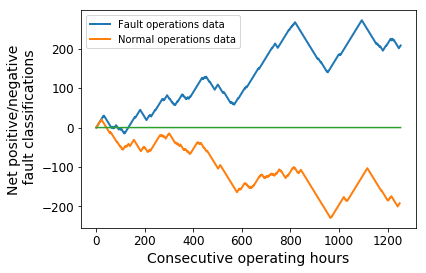

In [15]:
plt.plot(fault_votes, lw=2, label="Fault operations data")
plt.plot(nofault_votes, lw=2, label="Normal operations data")
#plt.plot(base, label="1/2")
plt.plot(np.zeros((len(fault_votes,))))
plt.ylabel("Net positive/negative\n fault classifications", fontsize=14)
plt.xlabel("Consecutive operating hours", fontsize=14)
#plt.title("logistic regression classifier performance")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

In [21]:
with open("seattle_logreg_classifier.skl", "wb") as d:
    pickle.dump(logreg_model_obj, d)

### Transfer from Summer to Winter w/ single building, single climate

In [16]:
shift=168  #just to get it away from the extreme ends of the seasons
season_i = [0+shift, 1595+shift, 2*1595+shift, 3*1595+shift]

#train initial for 2 weeks in winter
horizon = 168*2
start_i = 0+shift

X_train_s = X_all_poly[:,0+shift:0+shift+horizon]
Y_train_s = Y_all[:,0+shift:0+shift+horizon]

X_val_s = X_all_poly[:,0+shift+horizon:0+shift+2*horizon]
Y_val_s = Y_all[:,0+shift+horizon:0+shift+2*horizon]

params = {'FEATURE_DIM': X_all_poly.shape[0], 'OUTPUT_DIM': Y_all_pre.shape[0]}
winter_net = linear_nnet(params)

train_linear_state_estimation(winter_net, params, X_train_s, X_val_s, Y_train_s, Y_val_s, epochs=200, batch_size=24)
      
torch.save(winter_net, "winter_net.torch")



Validation MSE:  tensor(0.0023, grad_fn=<MseLossBackward>)


In [17]:
#transfer winter state transition matrix to summer

all_val_inds = np.arange(2*1594,3*1594,1)  #get all summer values
X_val_s = X_all_poly[:,all_val_inds]
Y_val_s = Y_all[:,all_val_inds]

validation_loss_transfer = []
validation_mape_transfer = []

num_hours = []

for s in range(25,horizon):
    num_hours.append(s + order)
    if s % 10 == 0:
        print("Training data size: ", s)
        
    params = {'FEATURE_DIM': X_all_poly.shape[0], 'OUTPUT_DIM': Y_all_pre.shape[0]}
    transfer_net = torch.load("winter_net.torch")
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(transfer_net.parameters(),lr=0.01, momentum=0.9)
    epochs = 200
    batch_size = 24           #this parameter seems to matter alot
    training_losses = []
        
    X_train_summer = X_all_poly[:,2*1594+shift:2*1594+shift+s]  #get summer training data
    Y_train_summer = Y_all[:,2*1594+shift:2*1594+shift+s]

    for e in range(epochs):
        training_losses = []
        X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_summer, Y_train_summer, batch_size)
        for i in enumerate(X_train_list):
            inp = Variable(torch.Tensor(X_train_list[i[0]].T))
            label = Variable(torch.Tensor(Y_train_list[i[0]].T))

            out = transfer_net(inp)
            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.data.item())

    inp_val = Variable(torch.Tensor(X_val_s.T))
    label_val = Variable(torch.Tensor(Y_val_s.T))
    out_val = transfer_net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_loss_transfer.append(loss_val.item())
    validation_mape_transfer.append(torch.mean(torch.abs(out_val - label_val)/label_val).item())

Training data size:  30
Training data size:  40
Training data size:  50
Training data size:  60
Training data size:  70
Training data size:  80
Training data size:  90
Training data size:  100
Training data size:  110
Training data size:  120
Training data size:  130
Training data size:  140
Training data size:  150
Training data size:  160
Training data size:  170
Training data size:  180
Training data size:  190
Training data size:  200
Training data size:  210
Training data size:  220
Training data size:  230
Training data size:  240
Training data size:  250
Training data size:  260
Training data size:  270
Training data size:  280
Training data size:  290
Training data size:  300
Training data size:  310
Training data size:  320
Training data size:  330


In [19]:
torch.save(transfer_net, "seattle_winter_to_summer_net.torch")

In [18]:
#set "inital" as random, train and validate in summer

horizon = 168*2
start_i = 0+shift

validation_loss_random = []
validation_mape_random = []

for s in range(25,horizon):
    num_hours.append(s + order)
    if s % 10 == 0:
        print("Training data size: ", s)
        
    params = {'FEATURE_DIM': X_all_poly.shape[0], 'OUTPUT_DIM': Y_all.shape[0]}
    random_net = linear_nnet(params)
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(random_net.parameters(),lr=0.01, momentum=0.9)
    epochs = 200
    batch_size = 24           #this parameter seems to matter alot
    training_losses = []
        
    X_train_summer = X_all_poly[:,2*1594+shift:2*1594+shift+s]  #get summer training data
    Y_train_summer = Y_all[:,2*1594+shift:2*1594+shift+s]

    for e in range(epochs):
        training_losses = []
        X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_summer, Y_train_summer, batch_size)
        for i in enumerate(X_train_list):
            inp = Variable(torch.Tensor(X_train_list[i[0]].T))
            label = Variable(torch.Tensor(Y_train_list[i[0]].T))

            out = random_net(inp)
            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.data.item())

    inp_val = Variable(torch.Tensor(X_val_s.T))
    label_val = Variable(torch.Tensor(Y_val_s.T))
    out_val = random_net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_loss_random.append(loss_val.item())
    validation_mape_random.append(torch.mean(torch.abs(out_val - label_val)/label_val).item())

Training data size:  30
Training data size:  40
Training data size:  50
Training data size:  60
Training data size:  70
Training data size:  80
Training data size:  90
Training data size:  100
Training data size:  110


KeyboardInterrupt: 

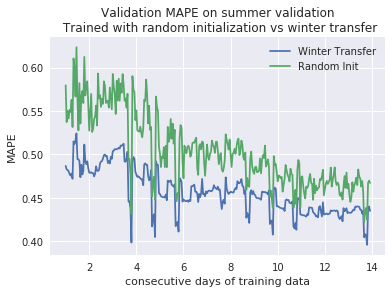

In [15]:
nh = np.asarray([float(i + 24) for i in range(len(validation_mape_transfer))])/24.0
plt.plot(nh, np.asarray(validation_mape_transfer), label="Winter Transfer")
plt.plot(nh, np.asarray(validation_mape_random), label="Random Init")
plt.legend()
plt.title("Validation MAPE on summer validation\n Trained with random initialization vs winter transfer")
plt.xlabel("consecutive days of training data")
plt.ylabel("MAPE")
plt.show()

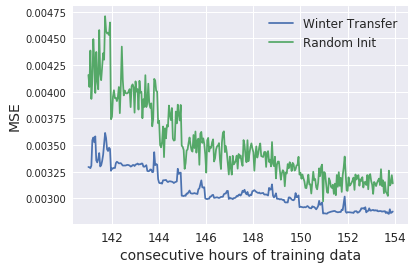

In [19]:
plt.plot(nh + lag, np.asarray(validation_loss_transfer), label="Winter Transfer")
plt.plot(nh + lag, np.asarray(validation_loss_random), label="Random Init")
plt.legend(fontsize=12)
#plt.title("Validation MSE on summer validation\n Trained with random initialization vs winter transfer")
plt.xlabel("consecutive hours of training data", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.show()

### Transfer A and classifier from winter to summer

In [22]:
#load state transition matrix

#net = torch.load("winter_net.torch")
net = torch.load("seattle_winter_to_summer_net.torch")
A_winter = copy.copy(net.l1.weight.data.numpy())

#transfer_net = torch.load("seattle_winter_to_summer_net.torch")

#transfer A with summer data, use new A to generate features

with open("seattle_logreg_classifier.skl", "rb") as d:
    logreg_model_obj = pickle.load(d)

In [28]:
shift=168  #just to get it away from the extreme ends of the seasons
season_i = [0+shift, 1595+shift, 2*1595+shift, 3*1595+shift]

shift = 2*1595+shift
#train initial for 2 weeks in winter
horizon = 168*2
start_i = 0+shift

In [29]:
X_train_s = X_all_poly[:,0+shift:0+shift+horizon]
Y_train_s = Y_all[:,0+shift:0+shift+horizon]

X_train_s_f = X_all_poly_f[:,0+shift:0+shift+horizon]
Y_train_s_f = Y_all_f[:,0+shift:0+shift+horizon]

X_val_s = X_all_poly[:,0+shift+horizon:0+shift+2*horizon]
Y_val_s = Y_all[:,0+shift+horizon:0+shift+2*horizon]
#classification training winter data
X_train_w, Y_train_w, X_train_w_f, Y_train_w_f = sample_classification_transform(A_winter, X_train_s, X_train_s_f, Y_train_s, Y_train_s_f)

X_train_lag_w_nf = lag_samples_array(X_train_w, lag)
Y_train_lag_w_nf = np.zeros((1,X_train_lag_w_nf.shape[1]))
    
X_train_lag_w_f = lag_samples_array(X_train_w_f, lag)
Y_train_lag_w_f = np.ones((1,X_train_lag_w_f.shape[1]))
    
X_train_w_sk = np.hstack((X_train_lag_w_nf, X_train_lag_w_f))
Y_train_w_sk = np.concatenate((Y_train_lag_w_nf, Y_train_lag_w_f), axis=1)


#classification validation winter data
X_val_s_f = X_all_poly_f[:,0+shift+horizon:0+shift+2*horizon]
Y_val_s_f = Y_all_f[:,0+shift+horizon:0+shift+2*horizon]

X_w, Y_w, X_w_f, Y_w_f = sample_classification_transform(A_winter, X_val_s, X_val_s_f, Y_val_s, Y_val_s_f)

X_val_lag_w_nf = lag_samples_array(X_w, lag)
Y_val_lag_w_nf = np.zeros((1,X_val_lag_w_nf.shape[1]))
    
X_val_lag_w_f = lag_samples_array(X_w_f, lag)
Y_val_lag_w_f = np.ones((1,X_val_lag_w_f.shape[1]))
    
X_val_w_sk = np.hstack((X_val_lag_w_nf, X_val_lag_w_f))
Y_val_w_sk = np.concatenate((Y_val_lag_w_nf, Y_val_lag_w_f), axis=1)




No fault data:  0.0 %
Fault data:  0.0 %
No fault data:  0.0 %
Fault data:  0.0 %


In [30]:
#use previously trained logistic regression classifier

Y_hat_val = logreg_model_obj.predict(X_val_w_sk.T)

p = sklearn.metrics.precision_score(Y_val_w_sk.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_w_sk.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

Transfer precision:  0.5
Transfer recall:  1.0


In [31]:
#transfer logistic regression classifier for fault/no fault


logreg_model_obj_w_transfer = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1, warm_start=False, solver="saga")#, n_jobs=-1, solver="saga")

logreg_model_obj_w_transfer.coef_ = copy.copy(logreg_model_obj.coef_)
logreg_model_obj_w_transfer.fit(X_train_w_sk.T, Y_train_w_sk.T)

Y_hat_val = logreg_model_obj.predict(X_val_w_sk.T)

p = sklearn.metrics.precision_score(Y_val_w_sk.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_w_sk.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


convergence after 6414 epochs took 14 seconds
Transfer precision:  0.5
Transfer recall:  1.0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s finished


[LibLinear]

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training precision:  0.6594594594594595
Training recall:  0.6224489795918368


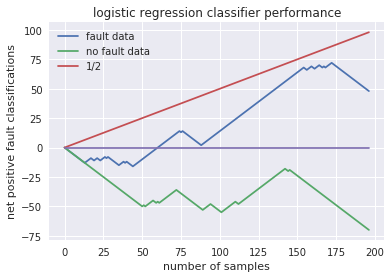

Validation precision:  0.5637254901960784
Validation recall:  0.5867346938775511


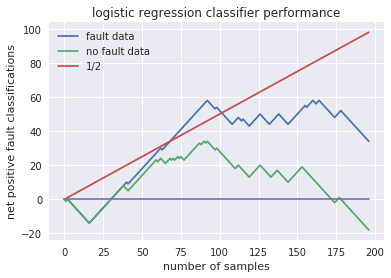

In [32]:
#train new logistic regression classifier

logreg_model_obj_w_raw = None #clear previous model cache if one exists --- speeds up training

logreg_model_obj_w_raw  = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1)#, n_jobs=-1, solver="saga")
logreg_model_obj_w_raw.fit(X_train_w_sk.T, Y_train_w_sk.T)

Y_hat = logreg_model_obj_w_raw.predict(X_train_w_sk.T)

p = sklearn.metrics.precision_score(Y_train_w_sk.T, Y_hat.T)
r = sklearn.metrics.recall_score(Y_train_w_sk.T, Y_hat.T)

print("Training precision: ", p)
print("Training recall: ", r)

plot_polling_val_data(X_train_w_sk, Y_train_w_sk, logreg_model_obj_w_raw)

Y_hat_val = logreg_model_obj_w_raw.predict(X_val_w_sk.T)

p = sklearn.metrics.precision_score(Y_val_w_sk.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_w_sk.T, Y_hat_val.T)

print("Validation precision: ", p)
print("Validation recall: ", r)

plot_polling_val_data(X_val_w_sk, Y_val_w_sk, logreg_model_obj_w_raw)

In [20]:
winter_A_p = p
winter_A_r = r

In [ ]:
#update A_winter to summer data

### Transfer to Phoenix: A and classifier from Seattle

In [21]:
#Load Seattle A

seattle_net = torch.load("seattle_net.torch")
A_seattle = copy.copy(seattle_net.l1.weight.data.numpy())

#Load Seattle classifier
with open("seattle_logreg_classifier.skl", 'rb') as d:
    logreg_seattle = pickle.load(d)
    


FileNotFoundError: [Errno 2] No such file or directory: 'seattle_net.torch'

In [5]:
#load and format Phoenix data

In [7]:
zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array(datapath + "refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre, Y_all_pre, X_v, Y_v = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_all, Y_all = normalize_data_set(X_all_pre, Y_all_pre, X_all_pre)

#kernelize
X_all_poly = polynomial_kernel_mat(X_all, poly_degree)

In [8]:
zone_temp_inds = [863,864,865]

Z_f, X_f, U_f = read_total_data_array(datapath + "refbuild_med_airfault/phoenix/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre_f, Y_all_pre_f, X_v_f, Y_v_f = split_train_val(Z_f, X_f, U_f, order=order, shuff=False, split_prop=1.0)
X_all_f, Y_all_f = normalize_data_set(X_all_pre_f, Y_all_pre_f, X_all_pre)

#kernelize
X_all_poly_f = polynomial_kernel_mat(X_all_f, poly_degree)

In [8]:
X, Y, X_f, Y_f = sample_classification_transform(A_seattle, X_all_poly, X_all_poly_f, Y_all, Y_all_f)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  63.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  63.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [9]:
#reformat for sklearn 

X_lag_nf = lag_samples_array(X, lag)
Y_lag_nf = np.zeros((1,X_lag_nf.shape[1]))
    
X_lag_f = lag_samples_array(X_f, lag)
Y_lag_f = np.ones((1,X_lag_f.shape[1]))
    
X_sk = np.hstack((X_lag_nf, X_lag_f))
Y_sk = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [10]:
#shuffle and train/val split

train_vals = np.random.choice(X_sk.shape[1], int(0.8*X_sk.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X_sk.shape[1]) if i not in train_vals ])

X_train_ph = X_sk[:,train_vals]
Y_train_ph = Y_sk[:,train_vals]

X_val_ph = X_sk[:,vals]
Y_val_ph = Y_sk[:,vals]

In [12]:
#use previously trained logistic regression classifier

Y_hat_val = logreg_seattle.predict(X_val_ph.T)

p = sklearn.metrics.precision_score(Y_val_ph.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_ph.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

Transfer precision:  0.5051916932907349
Transfer recall:  1.0


In [10]:
#update A and retest
X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=False, split_prop=0.2)
X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
X_val, Y_val = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)

#kernelize
X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
X_val_poly = polynomial_kernel_mat(X_val, poly_degree)

#start with Seattle NN
params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
train_linear_state_estimation(seattle_net, params, X_train_poly, X_val_poly, Y_train, Y_val, epochs=500, batch_size=24)

A_seattle = copy.copy(seattle_net.l1.weight.data.numpy())

Validation MSE:  tensor(0.0015, grad_fn=<MseLossBackward>)


In [11]:
X, Y, X_f, Y_f = sample_classification_transform(A_seattle, X_all_poly, X_all_poly_f, Y_all, Y_all_f)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  63.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  63.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [12]:
#reformat for sklearn 

X_lag_nf = lag_samples_array(X, lag)
Y_lag_nf = np.zeros((1,X_lag_nf.shape[1]))
    
X_lag_f = lag_samples_array(X_f, lag)
Y_lag_f = np.ones((1,X_lag_f.shape[1]))
    
X_sk = np.hstack((X_lag_nf, X_lag_f))
Y_sk = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [13]:
#shuffle and train/val split

train_vals = np.random.choice(X_sk.shape[1], int(0.8*X_sk.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X_sk.shape[1]) if i not in train_vals ])

X_train_ph = X_sk[:,train_vals]
Y_train_ph = Y_sk[:,train_vals]

X_val_ph = X_sk[:,vals]
Y_val_ph = Y_sk[:,vals]

In [14]:
#use previously trained logistic regression classifier

Y_hat_val = logreg_seattle.predict(X_val_ph.T)

p = sklearn.metrics.precision_score(Y_val_ph.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_ph.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

Transfer precision:  0.0
Transfer recall:  0.0


/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
#transfer previous logistic regression classifier
logreg_seattle_transfer = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1, warm_start=True)#, n_jobs=-1, solver="saga")
logreg_seattle_transfer.fit(X_train_ph.T, Y_train_ph.T)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]Transfer precision:  0.0
Transfer recall:  0.0


/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
#test transfered classifier
Y_hat_val = logreg_seattle_transfer.predict(X_val_ph.T)

p = sklearn.metrics.precision_score(Y_val_ph.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_ph.T, Y_hat_val.T)

print("Transfer precision: ", p)
print("Transfer recall: ", r)

Transfer precision:  0.5714285714285714
Transfer recall:  0.46325878594249204


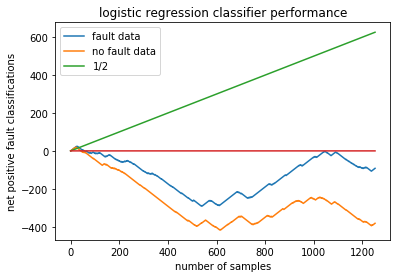

In [17]:
plot_polling_val_data(X_val_ph, Y_val_ph, logreg_seattle_transfer)